# **CUDA-Q Dynamics**

## Why dynamics simulations vs. circuit simulations?
CUDA-Q Dynamics is a powerful library enabling GPU-accelerated simulations of the time evolution of open and closed quantum systems. In contrast to quantum circuit simulation, which simulates the algorithmic output of the application of discrete logical quantum gates (eg X, Y, Z, CNOT, H, etc), dynamics simulations represent how quantum systems evolve in *time*, revealing important insights about the non-idealities of a quantum system, including how they interact with the environment and other quantum systems.

To make a classical analogy, the logic of a classical computer can be modeled using binary logic gates applied to transistor states, analogous to simulating the application of quantum logic gates to qubits. Dynamics simulations are an abstraction layer below this. Classically, to design better and higher-performing transistors, it's useful to fully model the device physics of the transistor itself, including fluctuations in voltage, capacitance, and current. Analogously, quantum dyanmics simulations can fully capture the physics of components beyond just the qubits, including drive pulses, resonators, couplers, and noise.

![alt text](images/Benchmarks.png)

Figure 1. Classical computing can be a helpful analogy for understanding the difference between algorithm and dynamics simulations. Image credits: Fredrik Brange (top right) and qutip-qip (bottom right)

## Functionality

CUDA-Q dynamics provides an easy API, `evolve`, to solve the Schrodinger and Lindblad Master equation, as well as number of commonly used [operators](https://nvidia.github.io/cuda-quantum/latest/using/dynamics.html#operator) to construct Hamiltonians. The basic order of operations is similar to other quantum dynamics frameworks. 
1. Define:
    - The dimensions of the system
    - The Hamiltonian
    - The initial state of the system
    - Any dissipation terms
    - The timesteps desired
2. Evolve!

Conveniently, this is the same programming model and API used to submit CUDA-Q jobs to analog quantum computers like QuEra and Pasqal. For simulation workloads, we also provide several commonly used [numerical integrators](https://nvidia.github.io/cuda-quantum/latest/using/dynamics.html#numerical-integrators).

In addition to this higher level functionality, we also provide a lower level library called [cuDensityMat](https://docs.nvidia.com/cuda/cuquantum/latest/cudensitymat/index.html) which provide the building blocks for accelerating custom solvers and other dynamics frameworks.

## Performance
CUDA-Q Dynamics shines for *large* system sizes, as is the case for most GPU workloads. We will see maximal speed-ups over CPU implementations with Hilbert spaces larger than $O(1000)$ levels. For systems of this size and larger, it is common to see speed-ups of >1000x. A benchmark modeling 100 timesteps of a system consisting of a 32-level transmon, 256-level resonator, and 4-level Purcell filter yielded a 1,140x speed-up in execution from single CPU (dual-socket Intel Xeon 8480CL) to single GPU (H100), or 1.5 days to 2 minutes.

CUDA-Q Dynamics also provides multi-GPU and multi-node capabilities to both increase the performance and scale of simulations. Additional GPUs can be pooled for additional memory to simulate larger systems (weak-scaling). Alternatively, with a fixed system size, additional GPUs can be pooled for increase performance (strong-scaling).

Full details of the benchmarks can be found in the blog [here](https://developer.nvidia.com/blog/accelerating-googles-qpu-development-with-new-quantum-dynamics-capabilities/).

## Section 1 - Simulating the Jaynes-Cummings Hamiltonian
The [Jaynes-Cummings](https://en.wikipedia.org/wiki/Jaynes%E2%80%93Cummings_model) (JC) Hamiltonian is a important theoretical model describing a two-level system interacting with a resonator. It describes how an atom or qubit fundamentally interacts with light. It is a powerful building block for modeling and designing many superconducting qubit systems and can be extended to describe many of the interactions in a superconducting qubit system. In practice, it describes the physics by which qubits can be controlled by external control pulses and the readout process used to determine their state.

![alt text](images/JC_model.png)

Figure 2. A two-level quantum system such as a qubit or an atom interacting with a light field confined by a resonator. The JC model describes this interaction. Image credit: Wikipedia.


The Hamiltonian can be simplified into the following three principal terms, by taking the rotating wave approximation, and dropping constant terms.

$\hat{H}_{JC} = \hat{H}_{cavity} +\hat{H}_{qubit} +\hat{H}_{interaction} $

with 

$\hat{H}_{cavity} = \hbar \omega_c \hat a^\dagger_c \hat a_c$ 

$\hat{H}_{qubit} = \hbar \omega_q \hat \sigma_+ \sigma_-$ 

$\hat{H}_{interaction} = \hbar g_c (\hat \sigma_+ \hat a_c + \hat \sigma_- \hat a^\dagger_c)$ 

In this section, we will simulate JC Hamiltonian. You will learn to:
- Define the dimensions of the system
- Construct the Hamiltonian with CUDA-Q `operators`
- Define the initial state of the system
- Execute the simulation with `cudaq.evolve()`

In [ ]:
# Import necessary packages
import cudaq
from cudaq import operators, ScalarOperator, Schedule, ScipyZvodeIntegrator, spin, RungeKuttaIntegrator
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

We start by setting the backend target to `dynamics`. Then, we define the degrees of freedom, specifying the number of levels associated with each one. We can then construct the Hamiltonian by applying the correct operators to the relevant degrees of freedom. Refer to the [CUDA-Q Dynamics](https://nvidia.github.io/cuda-quantum/latest/using/dynamics.html#id1) documentation for all built-in supported operators.

In [176]:
# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# System dimensions: atom (2-level system) and cavity (2-level system)
dimensions = {0: 2, 1: 2}

# Alias for commonly used operators
# Cavity operators
a = operators.annihilate(1)
a_dag = operators.create(1)

# Atom operators
sm = operators.annihilate(0)
sm_dag = operators.create(0)


# Defining the Hamiltonian for the system: self-energy terms and cavity-atom interaction term.
H_cav = 2 * np.pi * operators.number(1)
H_qubit = 2 * np.pi * operators.number(0)
H_int = 0.5 * np.pi * (sm * a_dag + sm_dag * a)

hamiltonian = H_cav + H_qubit + H_int

Initialize the states of the system in cupy arrays and define the time schedule:

In [177]:
# Initial state of the system
# Qubit in ground state
qubit_state = cp.array([[1.0, 0.0], [0.0, 0.0]], dtype=cp.complex128)

# Cavity in a state which has 1 photon initially
cavity_state = cp.zeros((2, 2), dtype=cp.complex128)
cavity_state[1][1] = 1.0

# Construct the Density Matrix
rho0 = cudaq.State.from_data(cp.kron(qubit_state, cavity_state))

# Define our timesteps
steps = np.linspace(0, 10, 201)
schedule = Schedule(steps, ["time"])

Evolve! Various observables can be collected at each time step. For this, we will track the population of both the qubit and the cavity in the absence of noise. In particular, we use ScipyZvodeIntegrator(). All available built-in numerical integrators can be found [here](https://nvidia.github.io/cuda-quantum/latest/using/dynamics.html#id3).

In [178]:
# Evolve the system
evolution_result = cudaq.evolve(
    hamiltonian,
    dimensions,
    schedule,
    rho0,
    observables=[operators.number(1), operators.number(0)],
    collapse_operators=[],
    store_intermediate_results=True,
    integrator=ScipyZvodeIntegrator())

Text(0.5, 1.0, 'No decay')

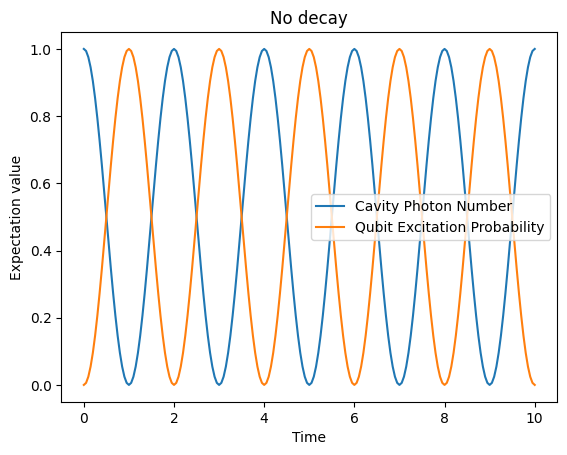

In [179]:
# Collect results
get_result = lambda idx, res: [
    exp_vals[idx].expectation() for exp_vals in res.expectation_values()
]

ideal_results = [
    get_result(0, evolution_result),
    get_result(1, evolution_result)
]

# Plot the results
plt.plot(steps, ideal_results[0])
plt.plot(steps, ideal_results[1])
plt.ylabel("Expectation value")
plt.xlabel("Time")
plt.legend(("Cavity Photon Number", "Qubit Excitation Probability"))
plt.title("No decay")

We see the qubit and cavity coherently exchanging population with a Rabi period of 2. Intuitively, a photon is being absorbed by the qubit and then re-emitted to the cavity. 

Recall that we set the coupling rate (Rabi frequency) in the interaction Hamiltonian to $g_c=\pi/2$. From performing some analysis on the JC Hamiltonian, one can derive that this oscillation rate is $\Omega_n = 2g_c \sqrt{n +1} = \pi \sqrt{n +1}$, where the effective subspace is spanned by $\{\ket{e,n},\ket{g,n+1}\}$. Is this consistent with what we observe?

## Exercise 1 - Simulating a many-photon Jaynes-Cummings Hamiltonian

Let us now adjust the code to simulate a larger system. Adjust the code below to now simulate 20 photons in the cavity.

In [180]:
# System dimensions: atom (2-level system) and cavity (20 photon system)
dimensions = {0: 2, 1: 21}

# Initial state of the system
# Qubit in ground state
qubit_state = cp.array([[1.0, 0.0], [0.0, 0.0]], dtype=cp.complex128)


# Cavity in a state which has 20 photons initially
cavity_state = cp.zeros((21, 21), dtype=cp.complex128)
cavity_state[20][20] = 1.0

# Construct the Density Matrix
rho0 = cudaq.State.from_data(cp.kron(qubit_state, cavity_state))

In [181]:
# Evolve the system
evolution_result = cudaq.evolve(
    hamiltonian,
    dimensions,
    schedule,
    rho0,
    observables=[operators.number(1), operators.number(0)],
    collapse_operators=[],
    store_intermediate_results=True,
    integrator=ScipyZvodeIntegrator())

Text(0.5, 1.0, '20 Photons')

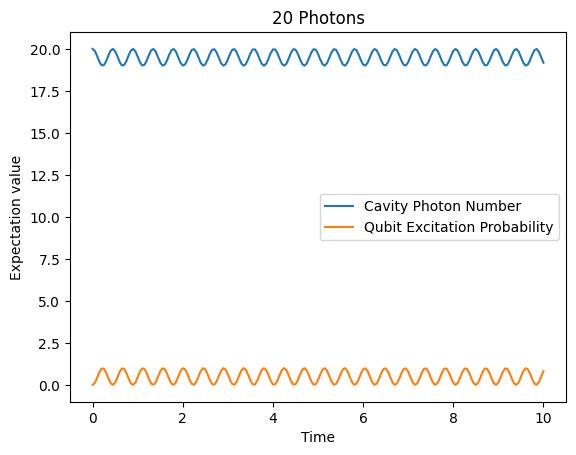

In [182]:
# Collect results
get_result = lambda idx, res: [
    exp_vals[idx].expectation() for exp_vals in res.expectation_values()
]

ideal_results = [
    get_result(0, evolution_result),
    get_result(1, evolution_result)
]

# Plot the results
plt.plot(steps, ideal_results[0])
plt.plot(steps, ideal_results[1])
plt.ylabel("Expectation value")
plt.xlabel("Time")
plt.legend(("Cavity Photon Number", "Qubit Excitation Probability"))
plt.title("20 Photons")

What do you observe about the new Rabi frequency? Is this consistent with what you expect?

## Section 2 - Simulating open quantum systems with the `collapse_operators`

In the previous section we simulated an idealized quantum system, isolated from the environment, with no noise. This is equivalent to solving the Schrodinger equation. Let us now add the effects of the environment, by adding noise to the system via the `collapse_operators`. We will now solve the Lindbladian:

$\dot \rho = -\frac{i}{\hbar} [H,\rho]+ \sum_i \gamma_i (L_i \rho L^\dagger_i-\frac{1}{2}\{L^\dagger_i L_i,\rho\})$

where we can assign the dissipation terms $L_i$ and rates $\gamma_i$.

In this section we will learn to use the `collapse_operators` to model noise in the system.

We can add a list of dissipation terms to the `collapse_operators` argument in `cudaq.evolve`. Let's add a photon loss mechanism with rate 0.1 with the `a` annihilation operator and observe what happens.

Text(0.5, 1.0, 'With decay')

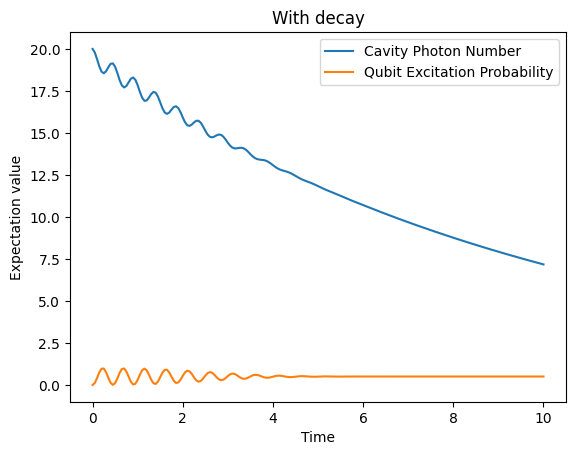

In [183]:
gamma=np.sqrt(0.1)

# Then, evolve the system with a collapse operator modeling cavity decay (leaking photons)
evolution_result_decay = cudaq.evolve(
    hamiltonian,
    dimensions,
    schedule,
    rho0,
    observables=[operators.number(1), operators.number(0)],
    collapse_operators=[gamma * a],
    store_intermediate_results=True,
    integrator=ScipyZvodeIntegrator())

get_result = lambda idx, res: [
    exp_vals[idx].expectation() for exp_vals in res.expectation_values()
]

decay_results = [
    get_result(0, evolution_result_decay),
    get_result(1, evolution_result_decay)
]

plt.plot(steps, decay_results[0])
plt.plot(steps, decay_results[1])
plt.ylabel("Expectation value")
plt.xlabel("Time")
plt.legend(("Cavity Photon Number", "Qubit Excitation Probability"))
plt.title("With decay")


Text(0.5, 1.0, 'Qubit State')

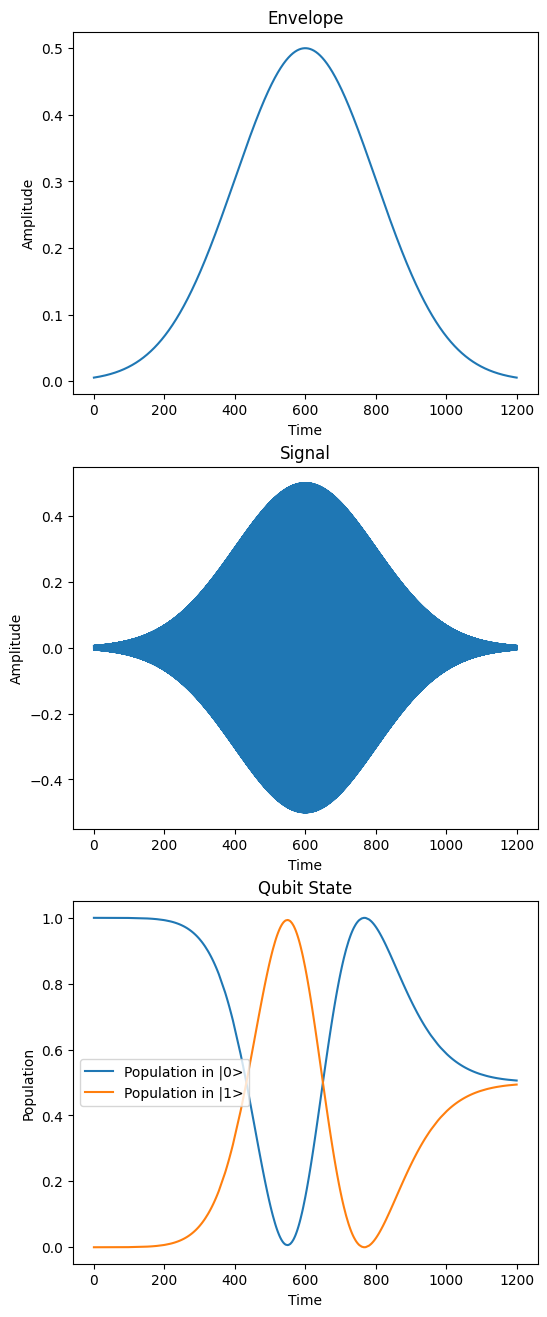

In [184]:
# This example simulates time evolution of a qubit (`transmon`) being driven by a pulse.
# The pulse is a modulated signal with a Gaussian envelop.
# The simulation is performed in the 'lab' frame.

# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# Device parameters
# Strength of the Rabi-rate in GHz.
rabi_rate = 0.01

# Frequency of the qubit transition in GHz.
omega = 5.0 * 2 * np.pi

# Define Gaussian envelope function to approximately implement a `rx(pi/2)` gate.
amplitude = 1. / 2.0  # Pi/2 rotation
sigma = 1.0 / rabi_rate / amplitude
pulse_duration = 6 * sigma


def gaussian(t, duration, amplitude, sigma):
    # Gaussian envelope function
    return amplitude * np.exp(-0.5 * (t - duration / 2)**2 / (sigma)**2)


def signal(t):
    # Modulated signal
    return np.cos(omega * t) * gaussian(t, pulse_duration, amplitude, sigma)


# Qubit Hamiltonian
hamiltonian = omega * spin.z(0) / 2
# Add modulated driving term to the Hamiltonian
hamiltonian += np.pi * rabi_rate * ScalarOperator(signal) * spin.x(0)

# Dimensions of sub-system. We only have a single degree of freedom of dimension 2 (two-level system).
dimensions = {0: 2}

# Initial state of the system (ground state).
psi0 = cudaq.State.from_data(cp.array([1.0, 0.0], dtype=cp.complex128))

# Schedule of time steps.
# Since this is a lab-frame simulation, the time step must be small to accurately capture the modulated signal.
dt = 1 / omega / 2
n_steps = int(np.ceil(pulse_duration / dt)) + 1
steps = np.linspace(0, pulse_duration, n_steps)
schedule = Schedule(steps, ["t"])

# Run the simulation.
# First, we run the simulation without any collapse operators (no decoherence).
evolution_result = cudaq.evolve(
    hamiltonian,
    dimensions,
    schedule,
    psi0,
    observables=[operators.number(0)],
    collapse_operators=[],
    store_intermediate_results=True,
    integrator=ScipyZvodeIntegrator())

pop1 = [
    exp_vals[0].expectation()
    for exp_vals in evolution_result.expectation_values()
]
pop0 = [1.0 - x for x in pop1]
fig = plt.figure(figsize=(6, 16))
envelop = [gaussian(t, pulse_duration, amplitude, sigma) for t in steps]

plt.subplot(3, 1, 1)
plt.plot(steps, envelop)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Envelope")

modulated_signal = [
    np.cos(omega * t) * gaussian(t, pulse_duration, amplitude, sigma)
    for t in steps
]
plt.subplot(3, 1, 2)
plt.plot(steps, modulated_signal)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Signal")

plt.subplot(3, 1, 3)
plt.plot(steps, pop0)
plt.plot(steps, pop1)
plt.ylabel("Population")
plt.xlabel("Time")
plt.legend(("Population in |0>", "Population in |1>"))
plt.title("Qubit State")

Text(0.5, 1.0, 'With decoherence')

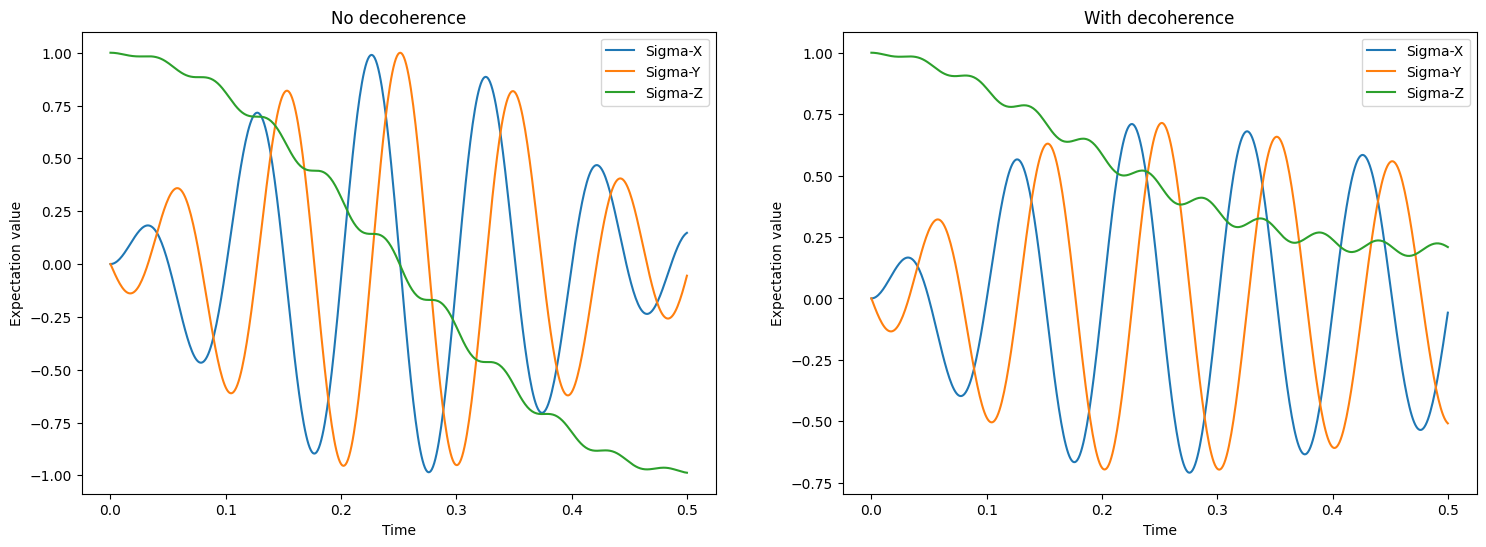

In [185]:
import cudaq
from cudaq import spin, ScalarOperator, Schedule, ScipyZvodeIntegrator
import numpy as np
import cupy as cp
import os
import matplotlib.pyplot as plt

# This example simulates time evolution of a qubit (`transmon`) being driven close to resonance in the presence of noise (decoherence).
# Thus, it exhibits Rabi oscillations.
# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# Qubit Hamiltonian reference: https://qiskit-community.github.io/qiskit-dynamics/tutorials/Rabi_oscillations.html
# Device parameters
# Qubit resonant frequency
omega_z = 10.0 * 2 * np.pi
# Transverse term
omega_x = 2 * np.pi
# Harmonic driving frequency
# Note: we chose a frequency slightly different from the resonant frequency to demonstrate the off-resonance effect.
omega_drive = 0.99 * omega_z

# Qubit Hamiltonian
hamiltonian = 0.5 * omega_z * spin.z(0)
# Add modulated driving term to the Hamiltonian
hamiltonian += omega_x * ScalarOperator(
    lambda t: np.cos(omega_drive * t)) * spin.x(0)

# Dimensions of sub-system. We only have a single degree of freedom of dimension 2 (two-level system).
dimensions = {0: 2}

# Initial state of the system (ground state).
rho0 = cudaq.State.from_data(
    cp.array([[1.0, 0.0], [0.0, 0.0]], dtype=cp.complex128))

# Schedule of time steps.
t_final = np.pi / omega_x
dt = 2.0 * np.pi / omega_drive / 100
n_steps = int(np.ceil(t_final / dt)) + 1
steps = np.linspace(0, t_final, n_steps)
schedule = Schedule(steps, ["t"])

# Run the simulation.
# First, we run the simulation without any collapse operators (no decoherence).
evolution_result = cudaq.evolve(
    hamiltonian,
    dimensions,
    schedule,
    rho0,
    observables=[spin.x(0), spin.y(0), spin.z(0)],
    collapse_operators=[],
    store_intermediate_results=True
    )

# Now, run the simulation with qubit decoherence
gamma_sm = 4.0
gamma_sz = 1.0
evolution_result_decay = cudaq.evolve(
    hamiltonian,
    dimensions,
    schedule,
    rho0,
    observables=[spin.x(0), spin.y(0), spin.z(0)],
    collapse_operators=[
        np.sqrt(gamma_sm) * spin.plus(0),
        np.sqrt(gamma_sz) * spin.z(0)
    ],
    store_intermediate_results=True)

get_result = lambda idx, res: [
    exp_vals[idx].expectation() for exp_vals in res.expectation_values()
]
ideal_results = [
    get_result(0, evolution_result),
    get_result(1, evolution_result),
    get_result(2, evolution_result)
]
decoherence_results = [
    get_result(0, evolution_result_decay),
    get_result(1, evolution_result_decay),
    get_result(2, evolution_result_decay)
]


fig = plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(steps, ideal_results[0])
plt.plot(steps, ideal_results[1])
plt.plot(steps, ideal_results[2])
plt.ylabel("Expectation value")
plt.xlabel("Time")
plt.legend(("Sigma-X", "Sigma-Y", "Sigma-Z"))
plt.title("No decoherence")

plt.subplot(1, 2, 2)
plt.plot(steps, decoherence_results[0])
plt.plot(steps, decoherence_results[1])
plt.plot(steps, decoherence_results[2])
plt.ylabel("Expectation value")
plt.xlabel("Time")
plt.legend(("Sigma-X", "Sigma-Y", "Sigma-Z"))
plt.title("With decoherence")

In [186]:
import numpy as np
from cudaq import *

omega_z = 1
omega_x = 1
omega_d = 1

# Qubit Hamiltonian
hamiltonian = 0.5 * omega_z * spin.z(0)
# Add modulated driving term to the Hamiltonian
hamiltonian += omega_x * ScalarOperator(lambda t: np.cos(omega_d * t)) * spin.x(0)

In [187]:
import cudaq
import numpy as np

# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# Dimensions of sub-systems: a single two-level system.
dimensions = {0: 2}

# Initial state of the system (ground state).
rho0 = np.array([[1.0, 0.0], [0.0, 0.0]], dtype=np.complex128)


# Schedule of time steps.
t_final = 1.0
n_steps = 5
steps = np.linspace(0, t_final, n_steps)
schedule = Schedule(steps, ["t"])

# Run the simulation.
evolution_result = evolve(hamiltonian,
                          dimensions,
                          schedule,
                          initial_state=cudaq.State.from_data(rho0),
                          observables=[spin.x(0),
                                       spin.y(0),
                                       spin.z(0)],
                          collapse_operators=[],
                          store_intermediate_results=True)

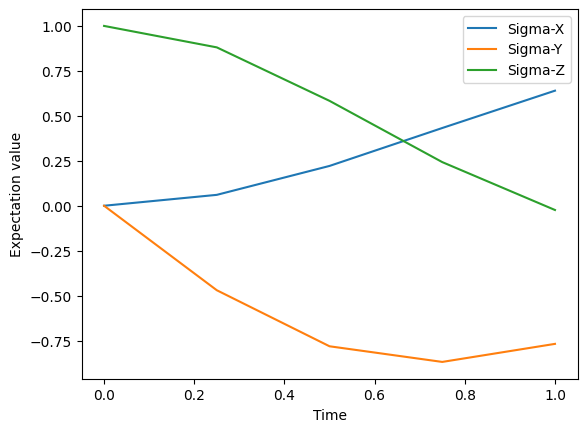

In [188]:
get_result = lambda idx, res: [
    exp_vals[idx].expectation() for exp_vals in res.expectation_values()
]

import matplotlib.pyplot as plt

plt.plot(steps, get_result(0, evolution_result))
plt.plot(steps, get_result(1, evolution_result))
plt.plot(steps, get_result(2, evolution_result))
plt.ylabel("Expectation value")
plt.xlabel("Time")
plt.legend(("Sigma-X", "Sigma-Y", "Sigma-Z"))